In [153]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import marsilea as ma

In [154]:
TOOL_DIR = "tools"
OUT_DIR = "../chapters/4_results_and_discussion/figures/quantification"
tools = [tool_csv[:-4] for tool_csv in os.listdir(TOOL_DIR)]
tools

['find_circ', 'segemehl', 'dcc', 'circexplorer2', 'ciriquant']

In [155]:
correct_total_counts = True

In [156]:
def parse_locstring(locstring: str):
    chrom, coords, strand = locstring.split(":")
    start, end = coords.split("-")
    return chrom, int(start), int(end), strand

In [157]:
def get_tool_data(tool: str, min_samples=1):
    df = pd.read_csv(os.path.join(TOOL_DIR, f"{tool}.csv"), sep='\t', index_col=0)
    df.fillna(0, inplace=True)
    
    df_stats = pd.DataFrame(index=df.index)
    df_stats["n_samples"] = (df>0).sum(axis=1)
    df_stats["total_counts"] = df.sum(axis=1)
    if correct_total_counts:
        df_stats["total_counts"] = df_stats["total_counts"] - df_stats["n_samples"]

    mask = df_stats['n_samples'] > min_samples
    df = df[mask]
    df_stats = df_stats[mask]

    df_loc = pd.DataFrame([parse_locstring(loc) for loc in df.index], columns=["chrom", "start", "end", "strand"], index=df.index)
    df_loc["tool"] = tool

    # Merge df_stats and df_loc
    df_stats = pd.concat([df_stats, df_loc], axis=1)

    return df, df_stats

In [158]:
def get_diff_groups(df_locs: pd.DataFrame, max_diff: int = 0):
    df_diff = df_locs.sort_values(["chrom", "end"])
    df_diff["end_group"] = df_diff.groupby("chrom")["end"].diff().gt(max_diff).cumsum()
    df_diff = df_diff.sort_values(["chrom", "start"])
    df_diff["start_group"] = df_diff.groupby("chrom")["start"].diff().gt(max_diff).cumsum()

    return df_diff

In [159]:
tool_counts = {}
tool_stats = {}

for tool in tools:
    tool_counts[tool], tool_stats[tool] = get_tool_data(tool)

df_stats = pd.concat(tool_stats.values(), axis=0)
df_diff = get_diff_groups(df_stats, 1)
df_diff

,n_samples,total_counts,chrom,start,end,strand,tool,end_group,start_group
id,,,,,,,,,
chr1:3290501-151796866:-,4,0.0,chr1,3290501,151796866,-,find_circ,6618,0
chr1:3435607-3435691:+,2,0.0,chr1,3435607,3435691,+,segemehl,0,1
chr1:3443360-3443455:+,2,0.0,chr1,3443360,3443455,+,segemehl,1,2
chr1:3542317-3542382:-,3,0.0,chr1,3542317,3542382,-,dcc,2,3
chr1:3584318-3584453:+,2,0.0,chr1,3584318,3584453,+,segemehl,3,4
...,...,...,...,...,...,...,...,...,...
chrY:90835262-90835371:-,5,0.0,chrY,90835262,90835371,-,segemehl,142496,141959
chrY:90835262-90835413:-,14,7.0,chrY,90835262,90835413,-,segemehl,142498,141959
chrY:90835270-90835406:-,5,0.0,chrY,90835270,90835406,-,segemehl,142497,141960


In [160]:
df_grouped = df_diff.groupby(["chrom", "start_group", "end_group"]).agg({
    "tool": list,
    "total_counts": list
})

df_grouped = df_grouped[df_grouped["tool"].apply(lambda x: len(set(x))) == 5]
df_grouped

tool  \
chrom start_group end_group                                                      
chr1  13          10         [find_circ, segemehl, circexplorer2, dcc, ciri...   
      50          48         [find_circ, segemehl, circexplorer2, dcc, ciri...   
                  49         [find_circ, segemehl, circexplorer2, dcc, ciri...   
      56          52         [find_circ, segemehl, circexplorer2, dcc, ciri...   
      95          97         [find_circ, segemehl, circexplorer2, dcc, ciri...   
...                                                                        ...   
chrX  141341      141906     [find_circ, segemehl, circexplorer2, dcc, ciri...   
      141356      141918     [find_circ, segemehl, circexplorer2, dcc, ciri...   
      141382      141945     [find_circ, segemehl, circexplorer2, dcc, ciri...   
      141399      141960     [find_circ, segemehl, circexplorer2, dcc, ciri...   
      141624      142180     [find_circ, segemehl, circexplorer2, dcc, ciri...   

                                             total_counts  
chrom start_group end_group                                
chr1  13          10            [0.0, 0.0, 0.0, 0.0, 0.0]  
      50          48            [0.0, 0.0, 0.0, 0.0, 1.0]  
                  49            [3.0, 3.0, 3.0, 3.0, 9.0]  
      56          52            [0.0, 0.0, 0.0, 0.0, 0.0]  
      95          97         [11.0, 19.0, 6.0, 6.0, 37.0]  
...                                                   ...  
chrX  141341      141906        [0.0, 0.0, 0.0, 0.0, 0.0]  
      141356      141918        [0.0, 0.0, 0.0, 0.0, 0.0]  
      141382      141945        [0.0, 0.0, 0.0, 0.0, 0.0]  
      141399      141960        [1.0, 1.0, 0.0, 0.0, 2.0]  
      141624      142180        [0.0, 0.0, 0.0, 0.0, 0.0]  

[5751 rows x 2 columns]

In [161]:
df_grouped["count_dict"] = df_grouped.apply(lambda row: dict(zip(row["tool"], row["total_counts"])), axis=1)
df_grouped.drop(columns=["tool", "total_counts"], inplace=True)

# Explode the count_dict
df_grouped = df_grouped["count_dict"].apply(pd.Series)
df_agg = pd.DataFrame(index=df_grouped.index)
df_agg["sum"]    = df_grouped.sum(axis=1)
df_agg["min"]    = df_grouped.min(axis=1)
df_agg["max"]    = df_grouped.max(axis=1)
df_agg["median"] = df_grouped.median(axis=1)

df_plot = pd.concat([df_grouped, df_agg], axis=1)
df_plot

find_circ  segemehl  circexplorer2  dcc  \
chrom start_group end_group                                            
chr1  13          10               0.0       0.0            0.0  0.0   
      50          48               0.0       0.0            0.0  0.0   
                  49               3.0       3.0            3.0  3.0   
      56          52               0.0       0.0            0.0  0.0   
      95          97              11.0      19.0            6.0  6.0   
...                                ...       ...            ...  ...   
chrX  141341      141906           0.0       0.0            0.0  0.0   
      141356      141918           0.0       0.0            0.0  0.0   
      141382      141945           0.0       0.0            0.0  0.0   
      141399      141960           1.0       1.0            0.0  0.0   
      141624      142180           0.0       0.0            0.0  0.0   

                             ciriquant   sum  min   max  median  
chrom start_group end_group                                      
chr1  13          10               0.0   0.0  0.0   0.0     0.0  
      50          48               1.0   1.0  0.0   1.0     0.0  
                  49               9.0  21.0  3.0   9.0     3.0  
      56          52               0.0   0.0  0.0   0.0     0.0  
      95          97              37.0  79.0  6.0  37.0    11.0  
...                                ...   ...  ...   ...     ...  
chrX  141341      141906           0.0   0.0  0.0   0.0     0.0  
      141356      141918           0.0   0.0  0.0   0.0     0.0  
      141382      141945           0.0   0.0  0.0   0.0     0.0  
      141399      141960           2.0   4.0  0.0   2.0     1.0  
      141624      142180           0.0   0.0  0.0   0.0     0.0  

[5751 rows x 9 columns]

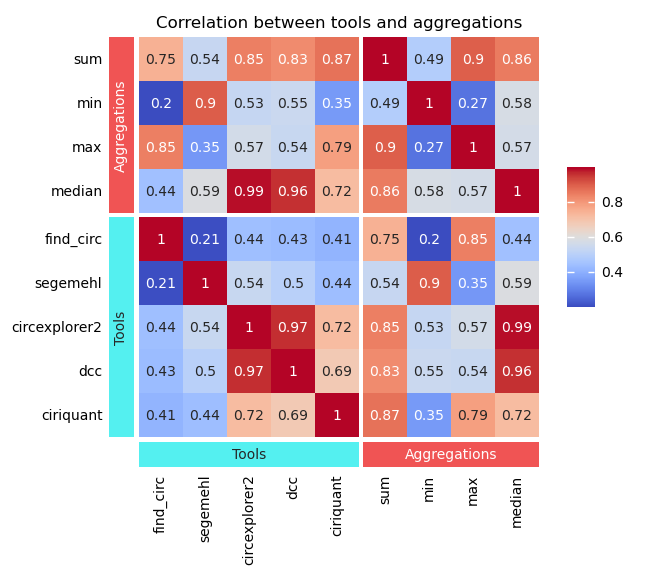

In [164]:
# Calculate the correlation matrix
corr = df_plot.corr()

h = ma.Heatmap(corr, annot=True)

categories = ["Tools", "Aggregations"]

h.group_cols([categories[0] if group in tools else categories[1] for group in corr.columns], order=categories)
h.group_rows([categories[0] if group in tools else categories[1] for group in corr.index], order=categories[::-1])
h.add_bottom(ma.plotter.Chunk(categories, fill_colors=["#54F0F0", "#F05454"]), pad=0.05)
h.add_bottom(ma.plotter.Labels(corr.columns), pad=0.05)
h.add_left(ma.plotter.Chunk(categories[::-1], fill_colors=["#54F0F0", "#F05454"][::-1]), pad=0.05)
h.add_left(ma.plotter.Labels(corr.index), pad=0.05)

h.add_legends("right")
h.add_title("Correlation between tools and aggregations")
h.save(os.path.join(OUT_DIR, "correlation_heatmap.png"))